In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
import numpy as np
from PIL import Image


# Это наша метрика на Tensorflow

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)


Загружаем картинки для сегментации (имена почти одинаковые: изображение.png - это сам кадр и изображение (1).png - это разметка)

Вот так загружаем с локального диска

In [3]:
from google.colab import files

uploaded = files.upload()



Saving small_segment.rar to small_segment.rar


In [5]:
!ls

images.zip  sample_data  small_segment.rar


Открываем архив (это зависит от архива)

In [ ]:
!pip install rarfile

In [ ]:
import rarfile

rf = rarfile.RarFile("small_segment.rar")
for f in rf.infolist():
    print(f.filename, f.file_size)
    if f.filename == "README":
        print(rf.read(f))
rf.extractall()

labels/00_000200.png 19401
labels/00_000400.png 14502
labels/00_000600.png 19818
labels/00_000800.png 13554
labels/00_001000.png 14496
labels/00_001200.png 17371
labels/00_001400.png 12431
labels/00_001600.png 16390
labels/00_001800.png 16646
labels/00_002000.png 14844
labels/00_002200.png 14011
labels/00_002400.png 16921
labels/00_002600.png 15822
labels/00_002800.png 13681
labels/00_003000.png 13980
labels/00_003200.png 15122
labels/00_003400.png 13978
images/00_000200.png 791603
images/00_000400.png 816531
images/00_000600.png 862976
images/00_000800.png 836923
images/00_001000.png 829576
images/00_001200.png 822001
images/00_001400.png 858981
images/00_001600.png 797385
images/00_001800.png 850589
images/00_002000.png 818966
images/00_002200.png 641760
images/00_002400.png 714888
images/00_002600.png 774166
images/00_002800.png 890605
images/00_003000.png 837876
images/00_003200.png 755342
images/00_003400.png 695524
labels/ 0
images/ 0


In [ ]:
!ls

images	labels	sample_data  small_segment.rar


А вот так загрузим картинки с Гугл Диска (делаем только один вариант загрузки)

In [4]:
from google.colab import drive
drive.mount('/gdrive')


Mounted at /gdrive


Прочитаем списки наших файлов (проверить идентичность, если имена одинаковые или собрать порядок чтения любым доступным способом)

In [6]:
import os, fnmatch
imag = os.listdir('/gdrive/My Drive/нейросети Ноутбуки для вебинаров Корлякова/урок 6/images/')
imag_label = os.listdir('/gdrive/My Drive/нейросети Ноутбуки для вебинаров Корлякова/урок 6/labels/')

In [7]:
imag,imag_label

(['00_001600.png',
  '00_001400.png',
  '00_002000.png',
  '00_003200.png',
  '00_001000.png',
  '00_002600.png',
  '00_001800.png',
  '00_000200.png',
  '00_000600.png',
  '00_001200.png',
  '00_003000.png',
  '00_000400.png',
  '00_003400.png',
  '00_000800.png',
  '00_002800.png',
  '00_002400.png',
  '00_002200.png'],
 ['00_001200.png',
  '00_001000.png',
  '00_002800.png',
  '00_002200.png',
  '00_001600.png',
  '00_002400.png',
  '00_001800.png',
  '00_002600.png',
  '00_003400.png',
  '00_000600.png',
  '00_000800.png',
  '00_000400.png',
  '00_003200.png',
  '00_003000.png',
  '00_000200.png',
  '00_002000.png',
  '00_001400.png'])

Задаю маршрут для чтения

In [8]:
PAHT_label = '/gdrive/My Drive/нейросети Ноутбуки для вебинаров Корлякова/урок 6/labels/'
PAHT_image = '/gdrive/My Drive/нейросети Ноутбуки для вебинаров Корлякова/урок 6/images/'
  

#Загружаем и уменьшаем картинки

можно обойтись исходным рахзмером или взять другой

ВАЖНО - размер по обеим сторонам должен делиться на 2 несколько раз (сколько будет сжатий кадра)

In [9]:
images = []
segments = []
image_size = (200,600)
for i_name in imag:
  images.append(image.load_img(PAHT_image+i_name ,target_size=image_size))
  segments.append(image.load_img(PAHT_label+i_name, target_size=image_size))


Посмотрели на входные кадры

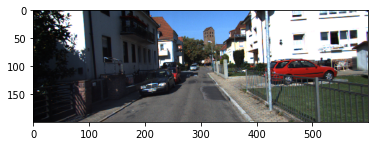

In [10]:
plt.imshow(images[0].convert('RGBA'))
plt.show()

Посмотрим на цели

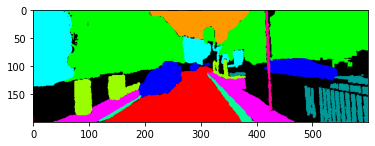

In [11]:
plt.imshow(segments[0].convert('RGBA'))
plt.show()

#Создаём обучающую выборку

Собираем входные примеры:

In [12]:
xTrain_Test = []

for img in images:
  x = image.img_to_array(img)
  xTrain_Test.append(x)

xTrain_Test = np.array(xTrain_Test)

In [13]:
print(xTrain_Test.shape)

(17, 200, 600, 3)


In [14]:
import cv2

Порстроим цвета , воспринимаемого диапазона для сегментированной картинки - это результат разметки, которую принесет разметчик

Color Coding:

Name	(r,g,b)	    7-Class mapping

Car	  ( 0, 0,255)	Object

Road	(255, 0, 0)	Road

Mark	(255,255, 0)	Road

Building	( 0,255, 0)	Building

Sidewalk	(255, 0,255)	Road

Tree/Bush	( 0,255,255)	Tree/Bush

Pole	(255, 0,153)	Sign/Pole

Sign	(153, 0,255)	Sign/Pole

Person	( 0,153,255)	Object

Wall	(153,255, 0)	Building

Sky	(255,153, 0)	Sky

Curb	( 0,255,153)	Road

Grass/Dirt	( 0,153,153)	Grass/Dirt

Void	( 0, 0, 0)	Void



Делаем конвертер в one-hot_encoding для выходных примеров

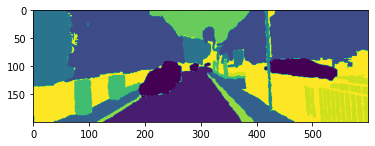

In [15]:
def Color2index(y):
  arr_col=[[0,0,255],[255,0,0],[255,255,0],[0,255,0],[255,0,255],[0,255,255],[255,0,153],[153,0,255],[0,153,255],[153,255,0],[255,153,0],[0,255,153],[0,153,153],[0,0,0]]
  y_ind = np.zeros((y.shape[0],y.shape[1]))
  y_cat = np.zeros((y.shape[0],y.shape[1], len(arr_col)))
  i = 1
  for i_color in arr_col:
    ind_i = np.where((y[:,:,0]==i_color[0])&(y[:,:,1]==i_color[1])&(y[:,:,2]==i_color[2]))
    y_ind[ind_i[0],ind_i[1]] = i
    y_cat[ind_i[0],ind_i[1], i-1] = 1 
    i += 1
  
  return y_cat, y_ind, i-1
cat_yi,ind_yi,h = Color2index(image.img_to_array(segments[0]))
plt.imshow(ind_yi.astype(float)/h)
plt.show()  


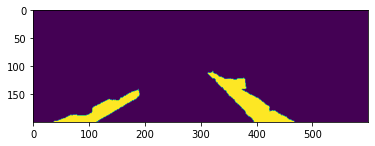

In [16]:
plt.imshow(cat_yi[:,:,4])
plt.show()

In [17]:
cat_yi.shape

(200, 600, 14)

Сегментированную картинку в  One hot encoding (разметка на 14 классов)**

In [18]:
yTrain_Test = []

for seg in segments:
  y_cat,_,_ = Color2index(image.img_to_array(seg))
  yTrain_Test.append(y_cat)

yTrain_Test = np.array(yTrain_Test)

In [19]:
print(yTrain_Test.shape)

(17, 200, 600, 14)


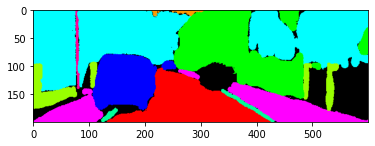

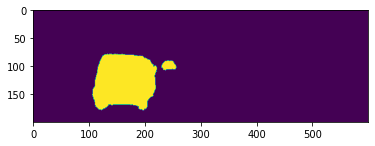

In [20]:
n = 10
plt.imshow(segments[n].convert('RGBA'))
plt.show()
img = yTrain_Test[n][:,:,0]
plt.imshow(img.astype(float))
plt.show()

Делим на тест и трейн по числу N

In [21]:
N = 15
yTrain = yTrain_Test[:N,:,:,:]
xTrain = xTrain_Test[:N,:,:,:]

yTest = yTrain_Test[N:,:,:,:]
xTest = xTrain_Test[N:,:,:,:]

In [22]:
yTest.shape

(2, 200, 600, 14)

In [23]:
print(xTrain.shape)
print(yTrain.shape)

(15, 200, 600, 3)
(15, 200, 600, 14)


#Создаём и обучаем U-net

In [24]:
from tensorflow.keras.utils import plot_model

**Unet**

In [25]:
def cuttedUnet(num_classes = 14, input_shape= (200, 600, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    #x = MaxPooling2D()(block_4_out)

    # Block 5
    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)


    # Load pretrained weights.
    #for_pretrained_weight = MaxPooling2D()(x)
    #vgg16 = Model(img_input, for_pretrained_weight)
    #vgg16.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

    # UP 1
    #x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = concatenate([x, block_4_out])
    #x = Conv2D(512, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 600, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 200, 600, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 200, 600, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 200, 600, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

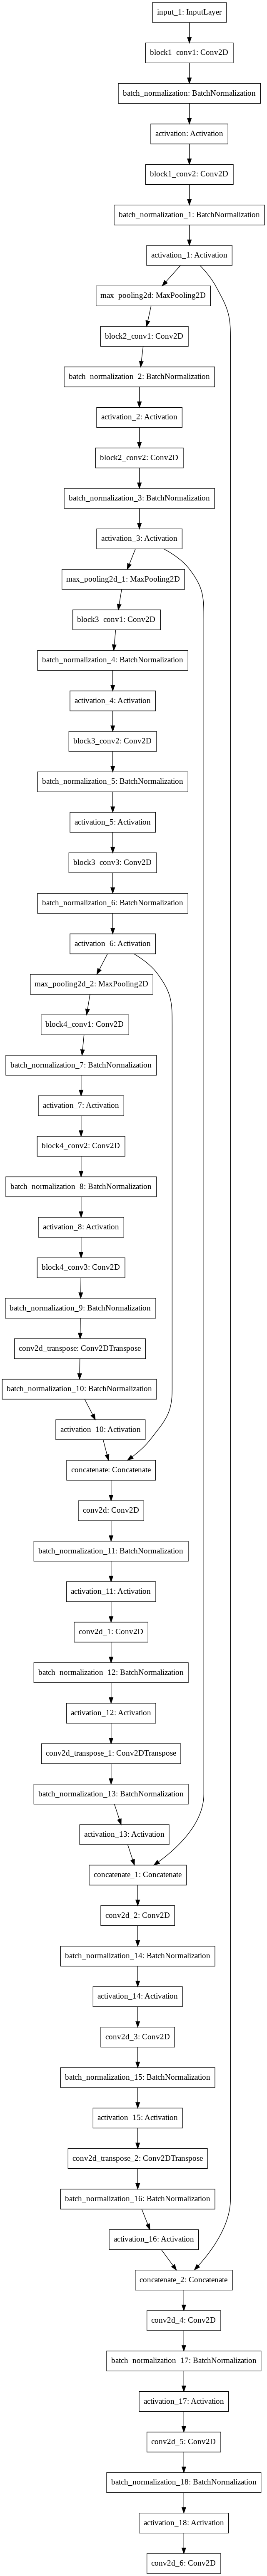

In [26]:
modelC = cuttedUnet(14, (200, 600, 3))

plot_model(modelC, to_file='modelC.png')

In [27]:

history = modelC.fit(xTrain, yTrain, epochs=10, batch_size=1, validation_data=(xTrain, yTrain))

Epoch 1/10
15/15 [==============================] - 3s 178ms/step - loss: 2.0231 - dice_coef: 0.2284 - val_loss: 15.3889 - val_dice_coef: 0.0444
Epoch 2/10
15/15 [==============================] - 2s 156ms/step - loss: 1.5843 - dice_coef: 0.3343 - val_loss: 14.4197 - val_dice_coef: 0.0966
Epoch 3/10
15/15 [==============================] - 2s 156ms/step - loss: 1.4309 - dice_coef: 0.3561 - val_loss: 11.2680 - val_dice_coef: 0.1772
Epoch 4/10
15/15 [==============================] - 2s 156ms/step - loss: 1.4200 - dice_coef: 0.3613 - val_loss: 12.4734 - val_dice_coef: 0.1584
Epoch 5/10
15/15 [==============================] - 2s 156ms/step - loss: 1.3510 - dice_coef: 0.3976 - val_loss: 10.5354 - val_dice_coef: 0.2861
Epoch 6/10
15/15 [==============================] - 2s 156ms/step - loss: 1.2746 - dice_coef: 0.4106 - val_loss: 9.9119 - val_dice_coef: 0.1449
Epoch 7/10
15/15 [==============================] - 2s 157ms/step - loss: 1.2360 - dice_coef: 0.4338 - val_loss: 6.8376 - val_dice_

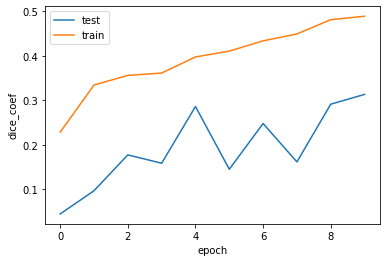

In [28]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

In [31]:
history = modelC.fit(xTrain, yTrain, epochs=10, batch_size=1, validation_data=(xTrain, yTrain))

Epoch 1/10
15/15 [==============================] - 3s 169ms/step - loss: 1.0797 - dice_coef: 0.5066 - val_loss: 2.3176 - val_dice_coef: 0.3752
Epoch 2/10
15/15 [==============================] - 2s 157ms/step - loss: 1.0119 - dice_coef: 0.5220 - val_loss: 1.9785 - val_dice_coef: 0.3649
Epoch 3/10
15/15 [==============================] - 2s 157ms/step - loss: 0.9716 - dice_coef: 0.5455 - val_loss: 1.9237 - val_dice_coef: 0.3280
Epoch 4/10
15/15 [==============================] - 2s 158ms/step - loss: 1.0746 - dice_coef: 0.5090 - val_loss: 1.7686 - val_dice_coef: 0.4301
Epoch 5/10
15/15 [==============================] - 2s 157ms/step - loss: 0.9754 - dice_coef: 0.5366 - val_loss: 1.6192 - val_dice_coef: 0.4099
Epoch 6/10
15/15 [==============================] - 2s 156ms/step - loss: 0.9302 - dice_coef: 0.5552 - val_loss: 1.3197 - val_dice_coef: 0.5384
Epoch 7/10
15/15 [==============================] - 2s 158ms/step - loss: 0.9575 - dice_coef: 0.5514 - val_loss: 2.5299 - val_dice_coef:

In [32]:
pred = modelC.predict(xTest)
print(pred.shape)

(2, 200, 600, 14)


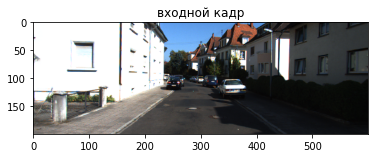

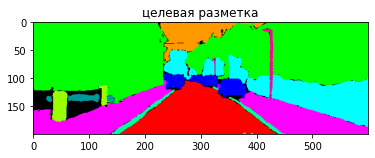

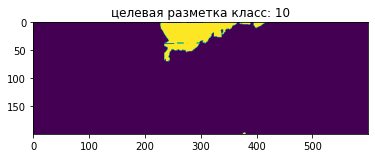

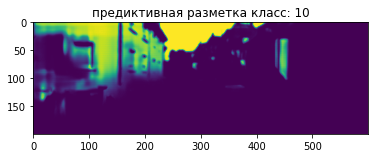

In [33]:
n = 1
class_ =10
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = pred[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()

**Претренированная  Unet**

In [34]:
 pre_trained_model = VGG16(input_shape=xTest.shape[1:], include_top=False, weights="imagenet")

58892288/58889256 [==============================] - 0s 0us/step


In [35]:
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 600, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 600, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 600, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 300, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 300, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 300, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 150, 128)      0     

In [36]:
def unet_pre_train(num_classes = 13, input_shape= (200, 600, 3)):    
    pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

    for layer in pre_trained_model.layers[:18]:
      layer.trainable = False
    x = pre_trained_model.layers[13].output
    block_4_out = pre_trained_model.layers[10].output
    block_3_out = pre_trained_model.layers[6].output
    block_2_out = pre_trained_model.layers[3].output
    img_input = pre_trained_model.inputs
    print(block_4_out)
    print(block_3_out)
    print(block_2_out)
    # UP 1

    # добавили перенос из понижаюшего плеча VGG16
    x = concatenate([x, block_4_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча VGG16
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча VGG16
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

Tensor("block3_pool/MaxPool_1:0", shape=(None, 25, 75, 256), dtype=float32)
Tensor("block2_pool/MaxPool_1:0", shape=(None, 50, 150, 128), dtype=float32)
Tensor("block1_pool/MaxPool_1:0", shape=(None, 100, 300, 64), dtype=float32)
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 200, 600, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 200, 600, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 200, 600, 64) 36928       block1_conv1[0][0]               
_______________________________________________________

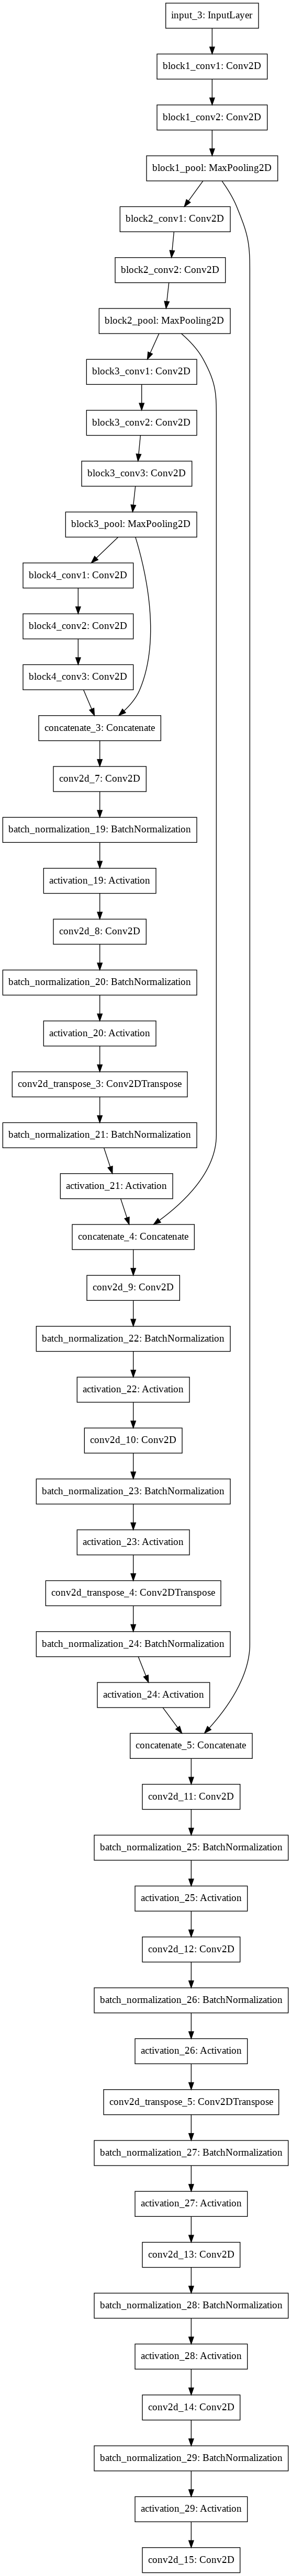

In [37]:
modelU = unet_pre_train(num_classes = 14, input_shape= (200, 600, 3))

plot_model(modelU, to_file='modelU.png')

In [38]:
history = modelU.fit(xTrain, yTrain, epochs=60, batch_size=3, validation_data=(xTrain, yTrain))

Epoch 1/60
5/5 [==============================] - 2s 352ms/step - loss: 2.2737 - dice_coef: 0.1734 - val_loss: 2.8797 - val_dice_coef: 0.2059
Epoch 2/60
5/5 [==============================] - 2s 319ms/step - loss: 1.6889 - dice_coef: 0.3015 - val_loss: 3.8210 - val_dice_coef: 0.2272
Epoch 3/60
5/5 [==============================] - 2s 316ms/step - loss: 1.4607 - dice_coef: 0.3686 - val_loss: 3.0216 - val_dice_coef: 0.2229
Epoch 4/60
5/5 [==============================] - 2s 317ms/step - loss: 1.3870 - dice_coef: 0.3780 - val_loss: 2.6245 - val_dice_coef: 0.2110
Epoch 5/60
5/5 [==============================] - 2s 318ms/step - loss: 1.2764 - dice_coef: 0.4217 - val_loss: 2.2288 - val_dice_coef: 0.2398
Epoch 6/60
5/5 [==============================] - 2s 317ms/step - loss: 1.2586 - dice_coef: 0.4300 - val_loss: 2.0615 - val_dice_coef: 0.2375
Epoch 7/60
5/5 [==============================] - 2s 316ms/step - loss: 1.1775 - dice_coef: 0.4468 - val_loss: 2.2576 - val_dice_coef: 0.1862
Epoch 

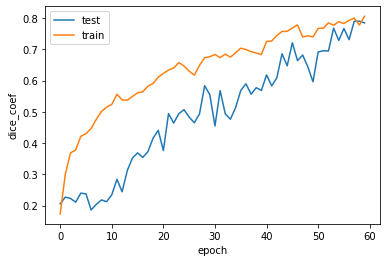

In [39]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

#Распознаём обучающую выборку

In [40]:
predu = modelU.predict(xTest)
print(pred.shape)


(2, 200, 600, 14)


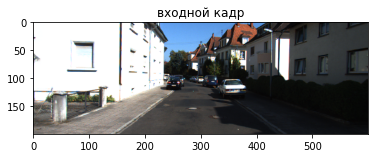

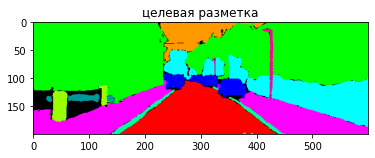

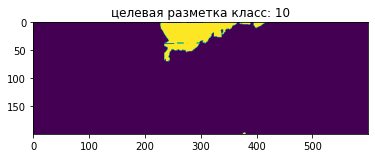

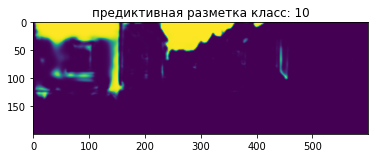

In [41]:
n = 1
class_ = 10
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = predu[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()


Что еще делаем:

- аугментацию
- ищем новые примеры
- проверяем разметку
- меняем модель